# GloFAS

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [2]:
import datetime

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.datasources import glofas, floodscan
from src.constants import *

In [3]:
BENUE_ADM2_PCODES = ["NG002016", "NG002009", "NG002021", "NG002005"]
fs = floodscan.load_adm2_daily_rasterstats()
fs = fs[fs["ADM2_PCODE"].isin(BENUE_ADM2_PCODES)]

In [4]:
fs_mean = fs.groupby(fs["time"].dt.year)["SFED_AREA"].mean().reset_index()
fs_mean = fs_mean.rename(columns={"time": "year"})

In [5]:
# glofas.process_reanalysis()

In [6]:
# glofas.download_reforecast()

In [7]:
# glofas.process_reforecast()

In [8]:
ref = glofas.load_reforecast()
rea = glofas.load_reanalysis()
rea = rea[rea["time"].dt.year.isin(ref["time"].dt.year.unique())]

In [9]:
ref

,time,dis24,valid_time,leadtime
0,2003-07-03,500.15625,2003-07-10,7
1,2003-07-03,577.60940,2003-07-05,2
2,2003-07-03,595.45310,2003-07-06,3
3,2003-07-03,552.92190,2003-07-07,4
4,2003-07-03,512.32810,2003-07-08,5
...,...,...,...,...
4895,2022-10-30,488.35156,2022-11-02,3
4896,2022-10-30,437.89844,2022-11-03,4
4897,2022-10-30,393.26562,2022-11-04,5
4898,2022-10-30,318.32030,2022-11-06,7


In [10]:
rp_f = 2
rp_a = 5

dfs = []

for lt in ref["leadtime"].unique():
    dff = ref[ref["leadtime"] <= lt]
    df_in = dff.loc[dff.groupby(dff["time"].dt.year)["dis24"].idxmax()]
    df_in["lt_max"] = lt
    thresh = df_in["dis24"].quantile(1 - 1 / rp_f)
    df_in["trigger"] = df_in["dis24"] > thresh
    print(lt, thresh)
    dfs.append(df_in)

ref_peaks = pd.concat(dfs, ignore_index=True)
ref_peaks["year"] = ref_peaks["time"].dt.year

7 2548.3867
2 2398.9336000000003
3 2434.0664
4 2434.0664
5 2434.0664
6 2434.0664
1 2222.15625


In [11]:
rea_peaks = rea.loc[rea.groupby(rea["time"].dt.year)["dis24"].idxmax()]
q = rea_peaks["dis24"].quantile(1 - 1 / rp_a)
rea_peaks["trigger"] = rea_peaks["dis24"] > q
rea_peaks["year"] = rea_peaks["time"].dt.year
rea_peaks["cerf"] = rea_peaks["year"].isin(CERF_YEARS)

In [12]:
rea_peaks["rank"] = rea_peaks["dis24"].rank(ascending=False)
rea_peaks["rp"] = len(rea_peaks) / rea_peaks["rank"]
rea_peaks = rea_peaks.sort_values("rank", ascending=False)

In [13]:
rea_peaks

,time,dis24,trigger,year,cerf,rank,rp
13411,2015-09-20,1563.8047,False,2015,False,20.0,1.000000
12658,2013-08-28,1611.9375,False,2013,True,19.0,1.052632
14113,2017-08-22,1717.8984,False,2017,False,18.0,1.111111
10127,2006-09-23,1733.7578,False,2006,False,17.0,1.176471
9381,2004-09-07,1856.5781,False,2004,False,16.0,1.250000
15248,2020-09-30,1946.8281,False,2020,False,15.0,1.333333
9723,2005-08-15,2077.3281,False,2005,False,14.0,1.428571
11205,2009-09-05,2169.9062,False,2009,False,13.0,1.538462
10491,2007-09-22,2235.7812,False,2007,False,12.0,1.666667
15530,2021-07-09,2253.2969,False,2021,False,11.0,1.818182


Text(0.5, 1.0, 'Benue river at Wuroboki\nGloFAS reanalysis (2003-2022)')

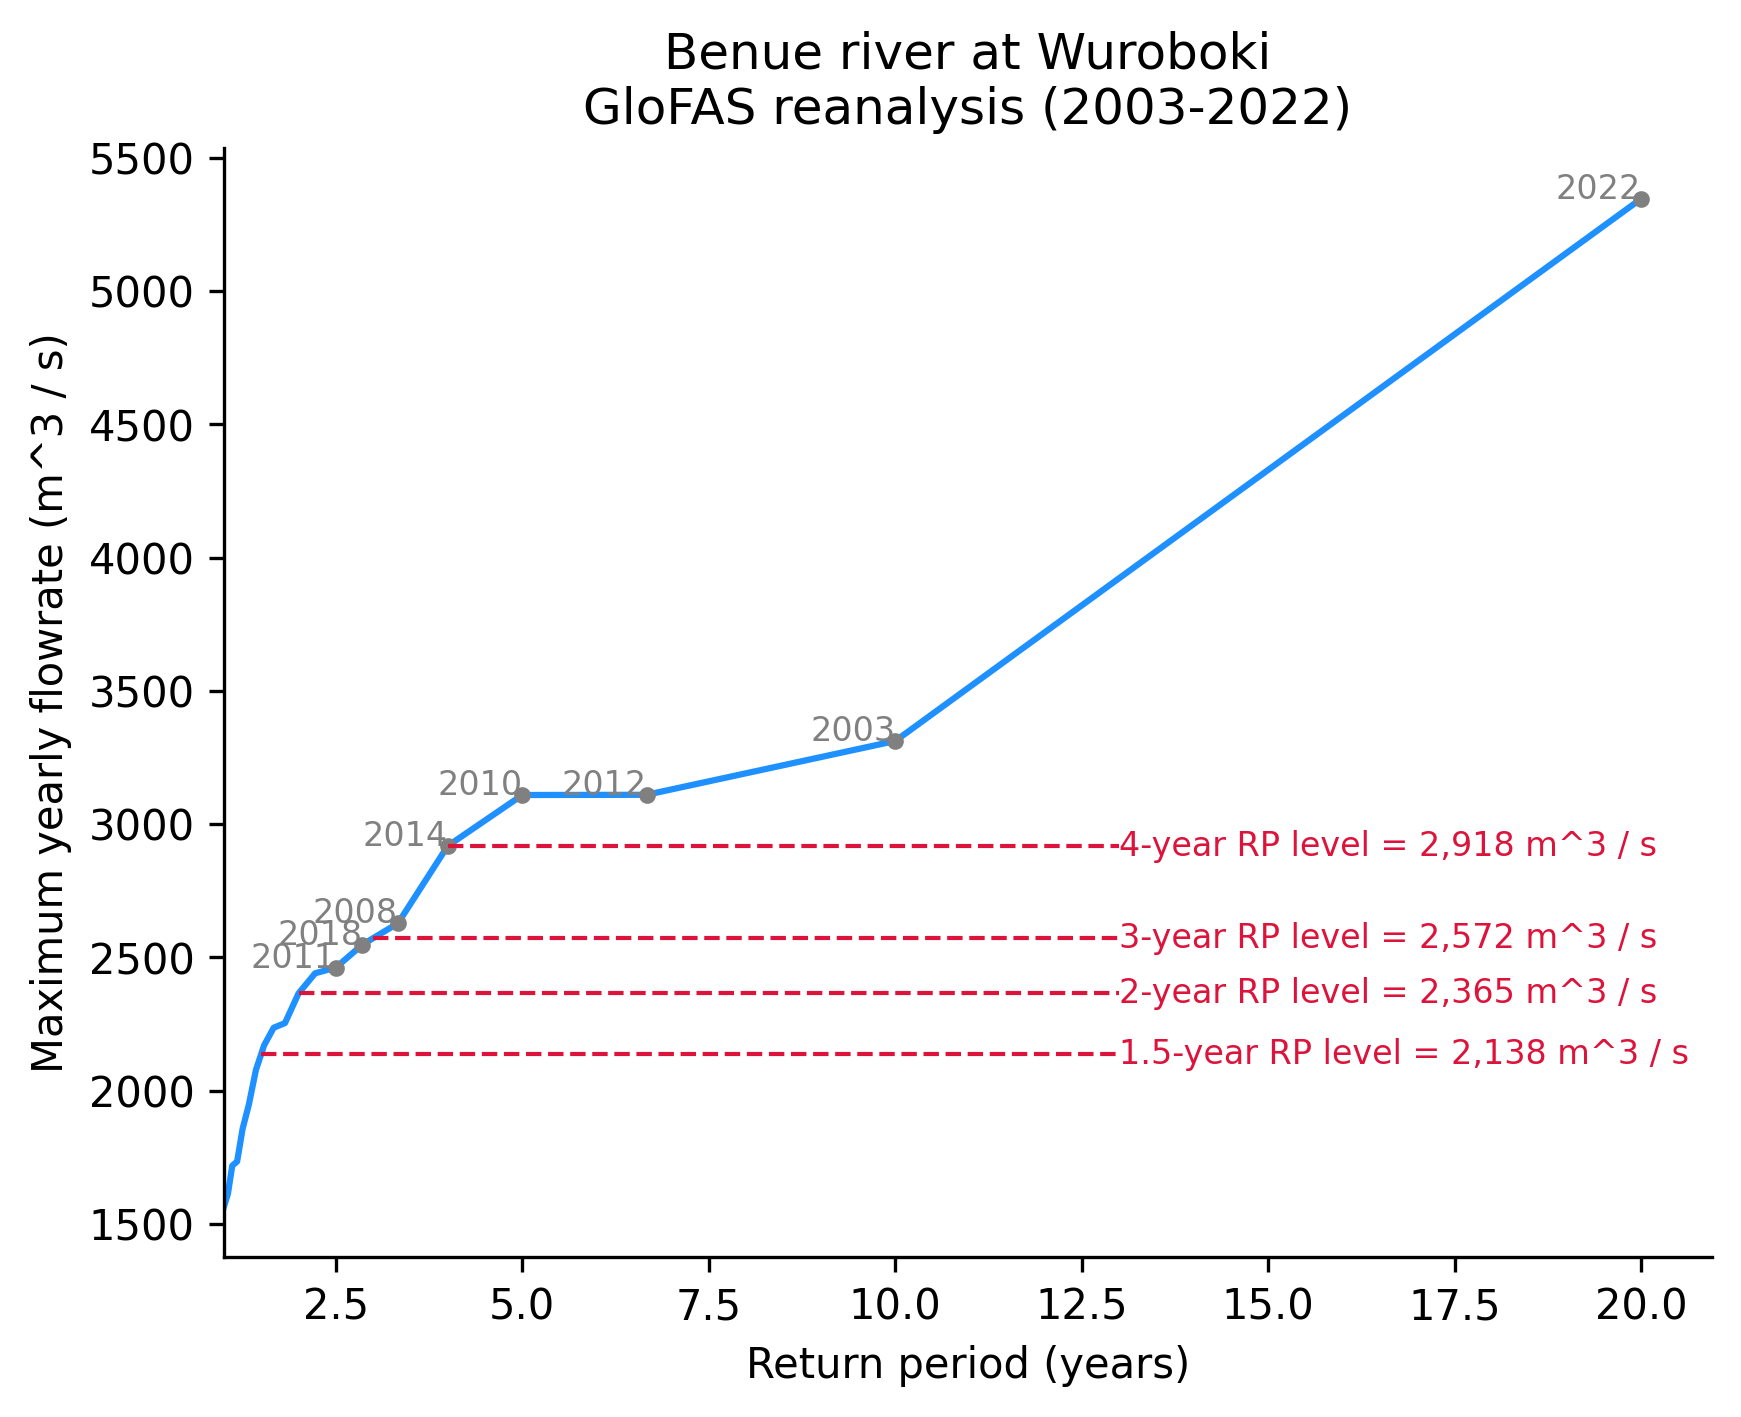

In [14]:
fig, ax = plt.subplots(dpi=300)
rea_peaks.plot(x="rp", y="dis24", ax=ax, legend=False, color="dodgerblue")

for year in rea_peaks.iloc[-8:]["year"]:
    x, y = rea_peaks.set_index("year").loc[year][["rp", "dis24"]]
    ax.plot(
        x,
        y,
        marker=".",
        color="grey",
    )
    ax.annotate(year, (x, y), ha="right", color="grey", fontsize=8)

annotation_x = 13

for rp in [1.5, 2, 3, 4]:
    y = np.interp(
        rp,
        rea_peaks["rp"],
        rea_peaks["dis24"],
    )
    ax.plot(
        [rp, annotation_x],
        [y, y],
        color="crimson",
        linestyle="--",
        linewidth=1,
    )
    ax.annotate(
        f"{rp}-year RP level = {y:,.0f} m^3 / s",
        (annotation_x, y),
        fontsize=8,
        color="crimson",
        va="center",
    )

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlim(left=1)
# ax.set_ylim(top=3500)
ax.set_xlabel("Return period (years)")
ax.set_ylabel("Maximum yearly flowrate (m^3 / s)")
ax.set_title("Benue river at Wuroboki\nGloFAS reanalysis (2003-2022)")

In [15]:
compare = rea_peaks.merge(ref_peaks, on="year", suffixes=["_a", "_f"]).merge(
    fs_mean
)
for indicator in ["cerf", "trigger_a"]:
    compare[f"TP_{indicator}"] = compare[indicator] & compare["trigger_f"]
    compare[f"FP_{indicator}"] = ~compare[indicator] & compare["trigger_f"]
    compare[f"TN_{indicator}"] = ~compare[indicator] & ~compare["trigger_f"]
    compare[f"FN_{indicator}"] = compare[indicator] & ~compare["trigger_f"]

compare = compare.sort_values(["year", "lt_max"])

In [16]:
dicts = []
for lt, group in compare.groupby("lt_max"):
    TPR = group["TP_trigger_a"].sum() / group["trigger_a"].sum()
    PPV = group["TP_trigger_a"].sum() / group["trigger_f"].sum()
    TPR_C = group["TP_cerf"].sum() / group["cerf"].sum()
    PPV_C = group["TP_cerf"].sum() / group["trigger_f"].sum()
    dicts.append(
        {"TPR": TPR, "PPV": PPV, "TPR_C": TPR_C, "PPV_C": PPV_C, "lt_max": lt}
    )

metrics = pd.DataFrame(dicts)

In [17]:
metrics

,TPR,PPV,TPR_C,PPV_C,lt_max
0,1.0,0.4,0.666667,0.2,1
1,1.0,0.4,0.666667,0.2,2
2,1.0,0.4,0.666667,0.2,3
3,1.0,0.4,0.666667,0.2,4
4,1.0,0.4,0.666667,0.2,5
5,1.0,0.4,0.666667,0.2,6
6,1.0,0.4,0.666667,0.2,7


Text(0.5, 1.0, 'Benue river at Wuroboki\nGloFAS yearly peaks (2003-2022)')

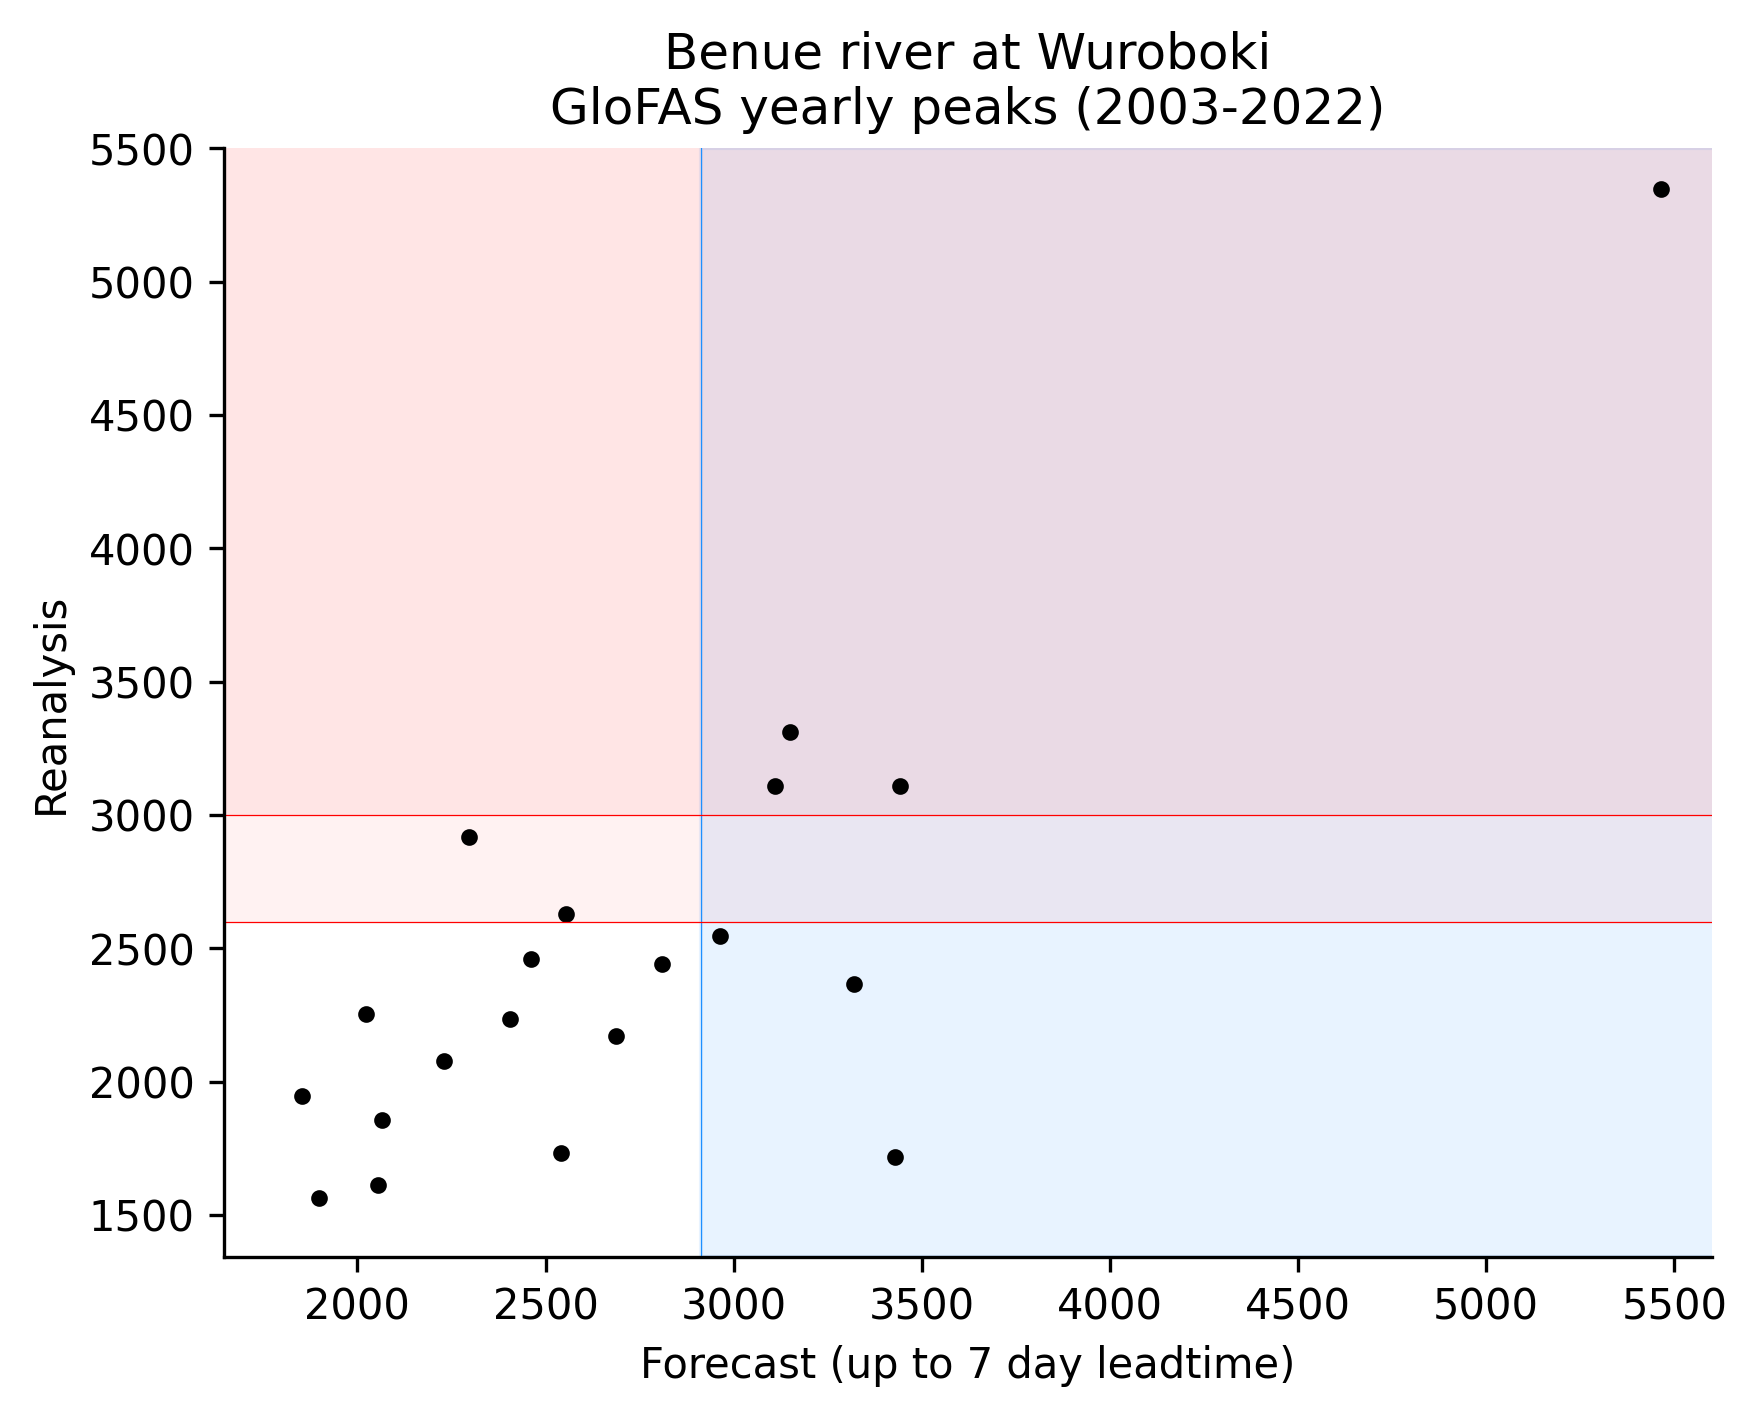

In [18]:
rp_a_3 = 2600
rp_a_5 = 3000
rp_f = 2911.802066666667
compare_lt = compare[compare["lt_max"] == 7]
fig, ax = plt.subplots(dpi=300)
compare_lt.plot(
    y="dis24_a",
    x="dis24_f",
    ax=ax,
    marker=".",
    color="k",
    linestyle="",
    legend=False,
)

ax.axvline(x=rp_f, color="dodgerblue", linestyle="-", linewidth=0.3)
ax.axvspan(
    rp_f,
    6000,
    ymin=0,
    ymax=1,
    color="dodgerblue",
    alpha=0.1,
)

ax.axhline(y=rp_a_3, color="red", linestyle="-", linewidth=0.3)
ax.axhspan(
    rp_a_3,
    6000,
    color="red",
    alpha=0.05,
    linestyle="None",
)

ax.axhline(y=rp_a_5, color="red", linestyle="-", linewidth=0.3)
ax.axhspan(
    rp_a_5,
    6000,
    color="red",
    alpha=0.05,
    linestyle="None",
)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylabel("Reanalysis")
ax.set_xlabel("Forecast (up to 7 day leadtime)")
ax.set_ylim(top=5500)
ax.set_xlim(right=5600)
ax.set_title("Benue river at Wuroboki\nGloFAS yearly peaks (2003-2022)")

In [19]:
compare_lt[compare_lt["trigger_f"]]

,time_a,dis24_a,trigger_a,year,cerf,rank,rp,time_f,dis24_f,valid_time,...,trigger_f,SFED_AREA,TP_cerf,FP_cerf,TN_cerf,FN_cerf,TP_trigger_a,FP_trigger_a,TN_trigger_a,FN_trigger_a
126,2003-09-19,3312.0156,True,2003,False,2.0,10.000000,2003-10-09,3150.7031,2003-10-15,...,True,0.005397,False,True,False,False,True,False,False,False
98,2008-08-27,2627.9766,False,2008,False,6.0,3.333333,2008-08-28,2555.2344,2008-08-29,...,True,0.002278,False,True,False,False,False,True,False,False
49,2009-09-05,2169.9062,False,2009,False,13.0,1.538462,2009-09-04,2687.7890,2009-09-06,...,True,0.002010,False,True,False,False,False,True,False,False
112,2010-09-07,3109.2578,True,2010,False,4.0,5.000000,2010-09-07,3110.9375,2010-09-08,...,True,0.005869,False,True,False,False,True,False,False,False
119,2012-08-21,3110.0781,True,2012,False,3.0,6.666667,2012-09-04,3441.2656,2012-09-11,...,True,0.026089,False,True,False,False,True,False,False,False
70,2016-09-22,2364.7734,False,2016,False,10.0,2.000000,2016-09-18,3320.4453,2016-09-25,...,True,0.011304,False,True,False,False,False,True,False,False
14,2017-08-22,1717.8984,False,2017,False,18.0,1.111111,2017-09-18,3428.1875,2017-09-25,...,True,0.006435,False,True,False,False,False,True,False,False
91,2018-09-28,2547.9062,False,2018,True,7.0,2.857143,2018-08-24,2963.4531,2018-08-30,...,True,0.013781,True,False,False,False,False,True,False,False
77,2019-10-11,2440.0547,False,2019,False,9.0,2.222222,2019-09-14,2808.5000,2019-09-20,...,True,0.005110,False,True,False,False,False,True,False,False
133,2022-08-19,5347.1720,True,2022,True,1.0,20.000000,2022-09-14,5464.1170,2022-09-20,...,True,0.027605,True,False,False,False,True,False,False,False


Text(0.5, 1.0, 'Benue river at Wuroboki\nGloFAS yearly peaks (2003-2022)')

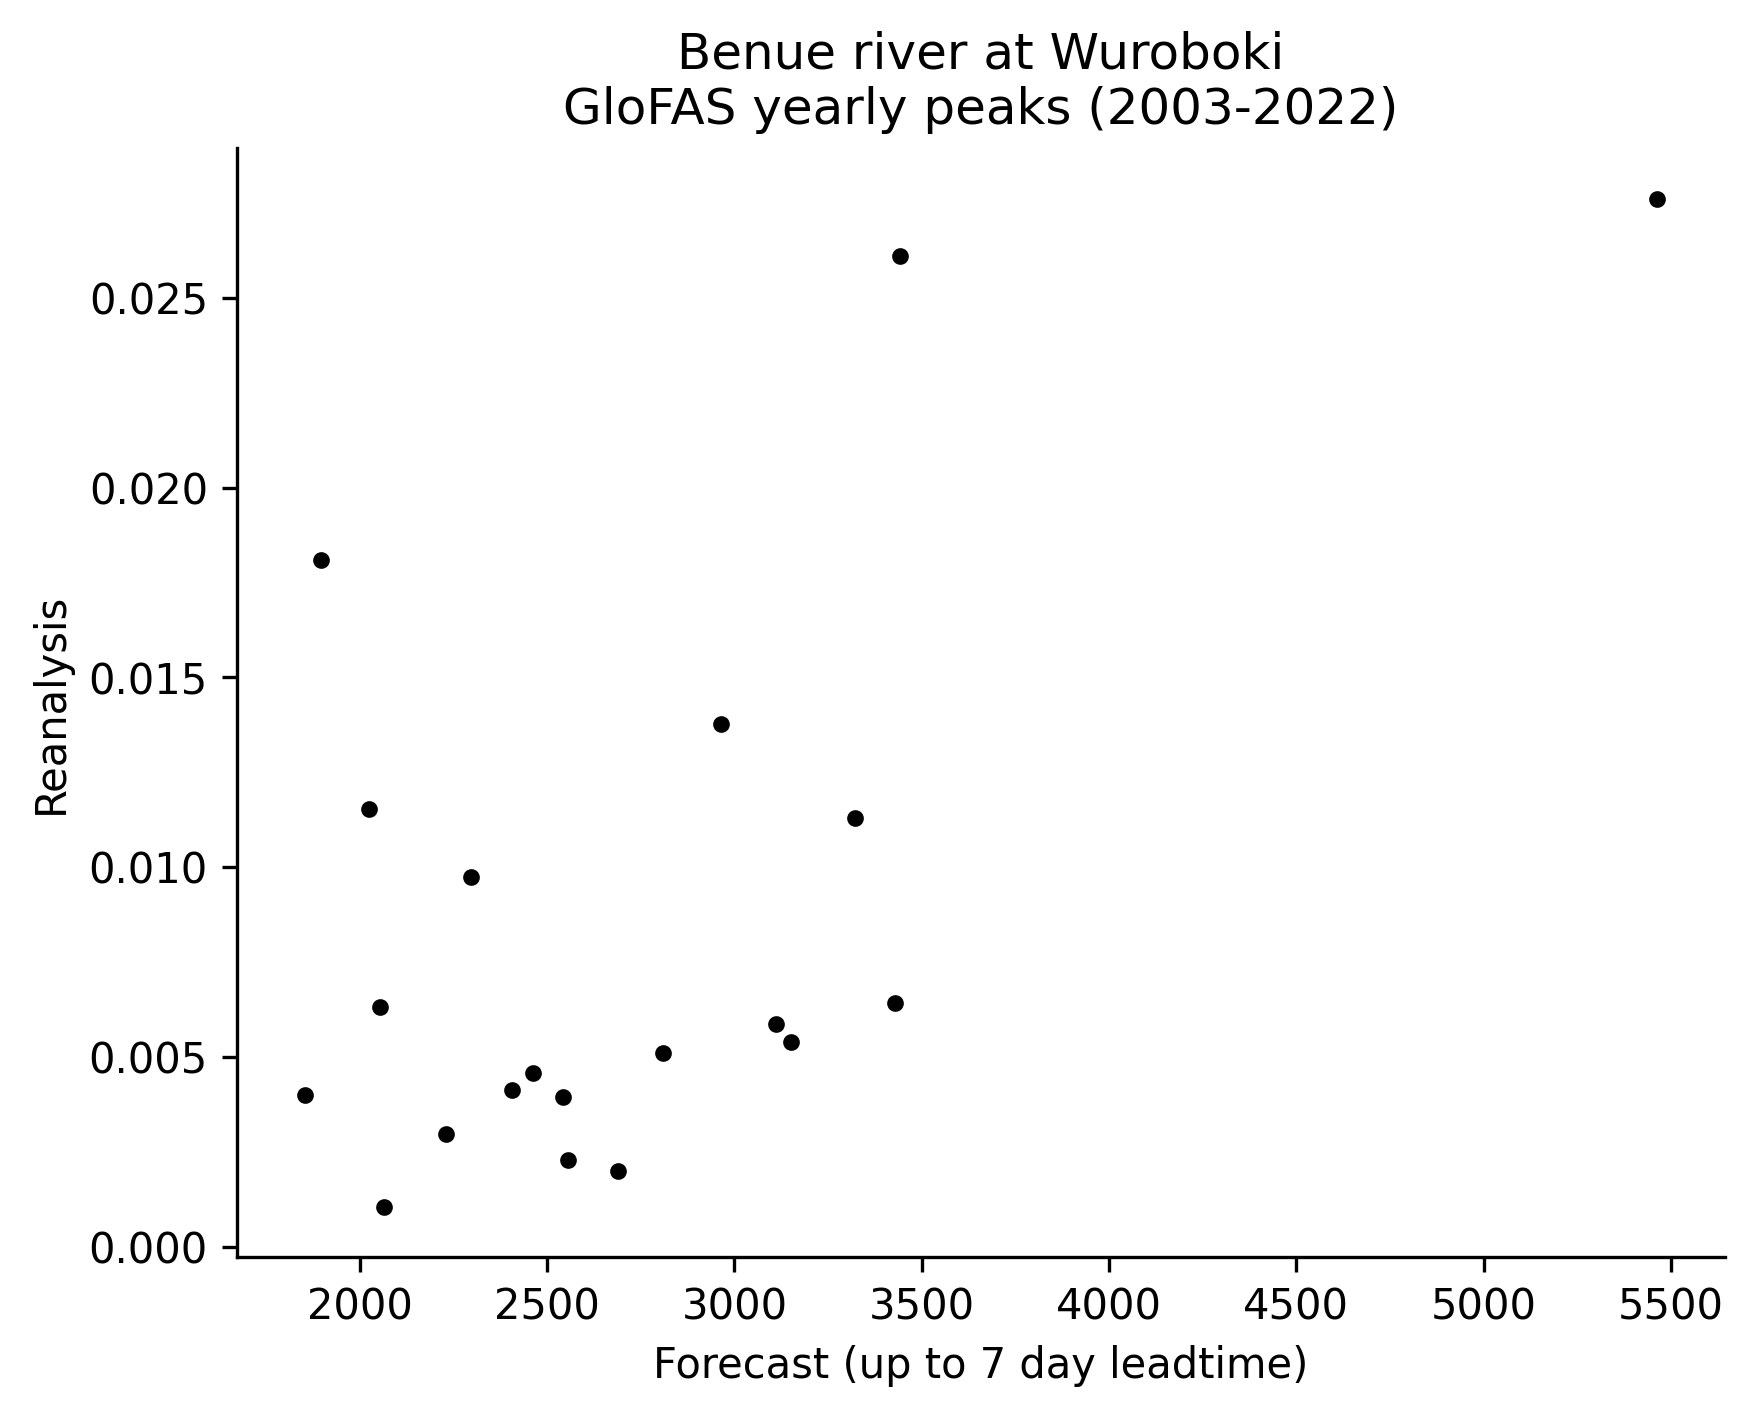

In [20]:
rp_a_3 = 2600
rp_a_5 = 3000
rp_f = 2911.802066666667
compare_lt = compare[compare["lt_max"] == 7]
fig, ax = plt.subplots(dpi=300)
compare_lt.plot(
    y="SFED_AREA",
    x="dis24_f",
    ax=ax,
    marker=".",
    color="k",
    linestyle="",
    legend=False,
)

# ax.axvline(x=rp_f, color="dodgerblue", linestyle="-", linewidth=0.3)
# ax.axvspan(
#     rp_f,
#     6000,
#     ymin=0,
#     ymax=1,
#     color="dodgerblue",
#     alpha=0.1,
# )

# ax.axhline(y=rp_a_3, color="red", linestyle="-", linewidth=0.3)
# ax.axhspan(
#     rp_a_3,
#     6000,
#     color="red",
#     alpha=0.05,
#     linestyle="None",
# )

# ax.axhline(y=rp_a_5, color="red", linestyle="-", linewidth=0.3)
# ax.axhspan(
#     rp_a_5,
#     6000,
#     color="red",
#     alpha=0.05,
#     linestyle="None",
# )

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylabel("Reanalysis")
ax.set_xlabel("Forecast (up to 7 day leadtime)")
# ax.set_ylim(top=5500)
# ax.set_xlim(right=5600)
ax.set_title("Benue river at Wuroboki\nGloFAS yearly peaks (2003-2022)")

In [21]:
compare[compare["lt_max"] == 1]

,time_a,dis24_a,trigger_a,year,cerf,rank,rp,time_f,dis24_f,valid_time,...,trigger_f,SFED_AREA,TP_cerf,FP_cerf,TN_cerf,FN_cerf,TP_trigger_a,FP_trigger_a,TN_trigger_a,FN_trigger_a
132,2003-09-19,3312.0156,True,2003,False,2.0,10.000000,2003-09-21,2760.4219,2003-09-22,...,True,0.005397,False,True,False,False,True,False,False,False
34,2004-09-07,1856.5781,False,2004,False,16.0,1.250000,2004-09-07,1857.3828,2004-09-08,...,False,0.001059,False,False,True,False,False,False,True,False
48,2005-08-15,2077.3281,False,2005,False,14.0,1.428571,2005-09-25,1923.4375,2005-09-26,...,False,0.002977,False,False,True,False,False,False,True,False
27,2006-09-23,1733.7578,False,2006,False,17.0,1.176471,2006-09-14,1693.7422,2006-09-15,...,False,0.003950,False,False,True,False,False,False,True,False
62,2007-09-22,2235.7812,False,2007,False,12.0,1.666667,2007-09-21,2148.9531,2007-09-22,...,False,0.004135,False,False,True,False,False,False,True,False
104,2008-08-27,2627.9766,False,2008,False,6.0,3.333333,2008-08-28,2555.2344,2008-08-29,...,True,0.002278,False,True,False,False,False,True,False,False
55,2009-09-05,2169.9062,False,2009,False,13.0,1.538462,2009-09-04,2063.2578,2009-09-05,...,False,0.002010,False,False,True,False,False,False,True,False
118,2010-09-07,3109.2578,True,2010,False,4.0,5.000000,2010-09-07,3110.9375,2010-09-08,...,True,0.005869,False,True,False,False,True,False,False,False
90,2011-09-14,2461.6250,False,2011,False,8.0,2.500000,2011-09-14,2462.2031,2011-09-15,...,True,0.004582,False,True,False,False,False,True,False,False
125,2012-08-21,3110.0781,True,2012,False,3.0,6.666667,2012-08-21,3096.9375,2012-08-22,...,True,0.026089,False,True,False,False,True,False,False,False


<Axes: xlabel='time'>

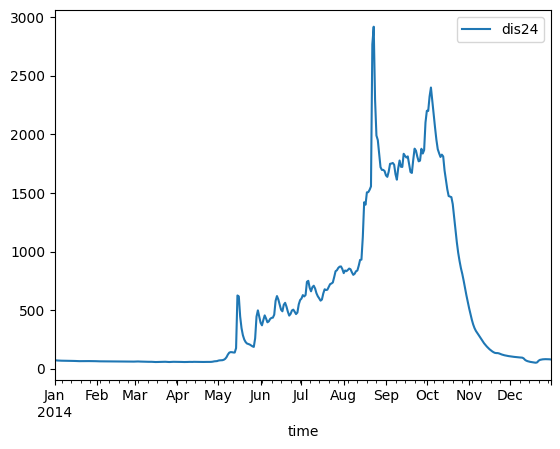

In [22]:
rea[rea["time"].dt.year == 2014].plot(x="time", y="dis24")

<Axes: xlabel='time'>

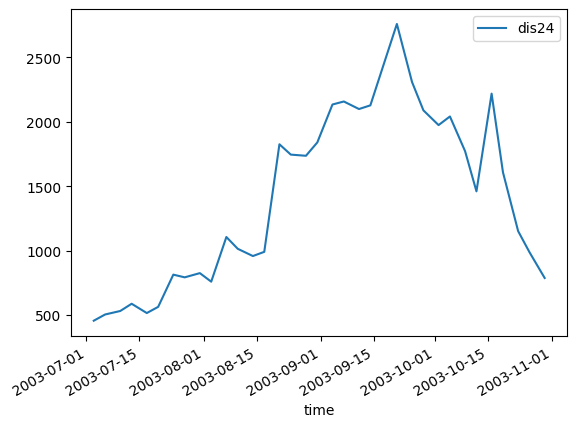

In [23]:
ref[(ref["time"].dt.year == 2003) & (ref["leadtime"] == 1)].plot(
    x="time", y="dis24"
)

<Axes: xlabel='time'>

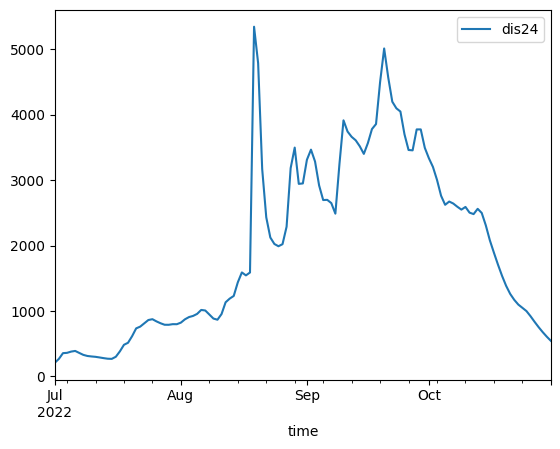

In [24]:
rea[(rea["time"] >= "2022-07-01") & (rea["time"] < "2022-11-01")].plot(
    x="time", y="dis24"
)

In [25]:
rea.loc[rea["dis24"].idxmax()]

time     2022-08-19 00:00:00
dis24               5347.172
Name: 15936, dtype: object